# Final Project Medical Imaging
# Point 2
Alejandro Cedillo Gamez

In [2]:
import pydicom
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import cv2
import scipy
from scipy.ndimage import zoom, rotate
from skimage import exposure
import helper as h

### Get Folder directories

In [3]:
fixed_10_folder = "1196/10_AP_Ax5.00mm"  # reference 
moving_30_folder    = "1196/30_EQP_Ax5.00mm"  # register


### Get all elements from directories

In [4]:
def get_slices(folder):
    all_slices = [
        pydicom.dcmread(os.path.join(root, fname))
        for root, _, files in os.walk(folder)
        for fname in sorted(files)
        if fname.lower().endswith('.dcm')
    ]
    return all_slices

In [5]:
moving_slices = get_slices(moving_30_folder)
fixed_slices = get_slices(fixed_10_folder)

In [6]:
moving_slices[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 180
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.5.34343107.11676.1605770289.644
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4-JP'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'REFORMATTED', 'AVERAGE']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0013) Instance Creation Time              TM: '110603'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0017) Acquisition UID

### Load volume from slices

In [7]:
def get_volume(slices):
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    my_volume = np.stack([s.pixel_array for s in slices], axis=0)
    return my_volume

In [8]:
moving_vol = get_volume(moving_slices)
fixed_vol = get_volume(fixed_slices)

In [9]:
z_positions = [float(ds.ImagePositionPatient[2]) for ds in moving_slices]

### Preprocess data

In [10]:
# fixed_vol = rotate(fixed_vol, 180, axes=(0, 2), reshape=False)
# moving_vol = rotate(fixed_vol, 180, axes=(0, 2), reshape=False)


In [11]:
fixed_vol   = h.normalize(fixed_vol)
moving_vol  = h.normalize(moving_vol)

In [12]:
moving_vol = np.flip(moving_vol,axis=0)
fixed_vol = np.flip(fixed_vol,axis=0)

### Spacing between elements
```
spacing = ( 
    float(slices[0].SpacingBetweenSlices),  # Δz (slice thickness) 
    float(slices[0].PixelSpacing[0]),       # Δy (row spacing) 
    float(slices[0].PixelSpacing[1])        # Δx (column spacing) 
)
```

- See: https://dicom.innolitics.com/ciods/rt-dose/image-plane/00280030
- See: https://dicom.innolitics.com/ciods/ct-performed-procedure-protocol/performed-ct-reconstruction/00189934/00180088

In [13]:
slice_thickness = abs(z_positions[1] - z_positions[0])
slice_thickness

5.0

In [14]:
# We need to know the pixel spacing of the slices to rescale the images, and have the right aspect ratio (mm/pixel)
# The pixel spacing is the same for all slices, so we can just take the first slice
moving_slices[0].PixelSpacing # x and y pixel spacing

[0.703125, 0.703125]

In [15]:
fixed_slices[0].PixelSpacing

[0.703125, 0.703125]

In [16]:
# now that we know moving_slices[0].PixelSpacing[0] and moving_slices[0].PixelSpacing[1] are the same value
# we can save just one
mov_spacing_val = float(moving_slices[0].PixelSpacing[0])
fixed_spacing_val = float(fixed_slices[0].PixelSpacing[0])

pixel_len_mm = [slice_thickness, mov_spacing_val]


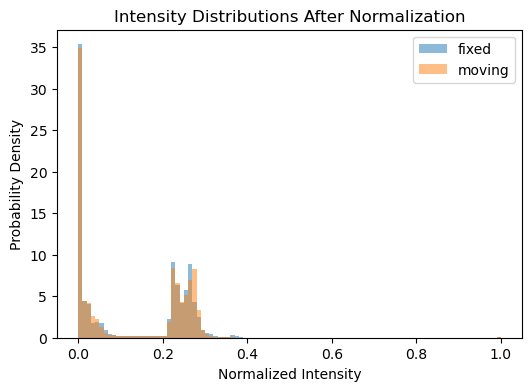

In [17]:
import matplotlib.pyplot as plt

# assume fixed_vol and moving_vol are your normalized NumPy arrays
fixed_vals  = fixed_vol .ravel()
moving_vals = moving_vol.ravel()

plt.figure(figsize=(6,4))
plt.hist(fixed_vals,  bins=100, alpha=0.5, label='fixed',  density=True)
plt.hist(moving_vals, bins=100, alpha=0.5, label='moving', density=True)
plt.title("Intensity Distributions After Normalization")
plt.xlabel("Normalized Intensity")
plt.ylabel("Probability Density")
plt.legend()
plt.show()


Text(0.5, 1.0, 'Sagittal Plane (moving)')

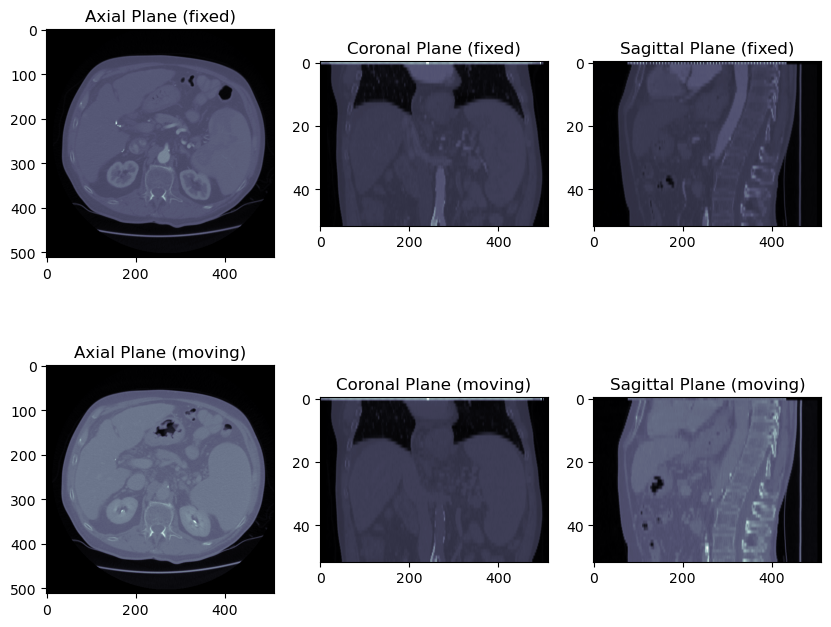

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

axs[0, 0].imshow(fixed_vol[fixed_vol.shape[0] // 2, :, :], cmap='bone', aspect=1)
axs[0, 0].set_title("Axial Plane (fixed)")
axs[0, 1].imshow(fixed_vol[:, fixed_vol.shape[1] // 2, :], cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
axs[0, 1].set_title("Coronal Plane (fixed)")
axs[0, 2].imshow(fixed_vol[:, :, fixed_vol.shape[2] // 2], cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
axs[0, 2].set_title("Sagittal Plane (fixed)")


# scan_3d visualization
axs[1, 0].imshow(moving_vol[moving_vol.shape[0] // 2, :, :], cmap='bone', aspect=1)
axs[1, 0].set_title("Axial Plane (moving)")
axs[1, 1].imshow(moving_vol[:, moving_vol.shape[1] // 2, :], cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
axs[1, 1].set_title("Coronal Plane (moving)")
axs[1, 2].imshow(moving_vol[:, :, moving_vol.shape[2] // 2], cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
axs[1, 2].set_title("Sagittal Plane (moving)")

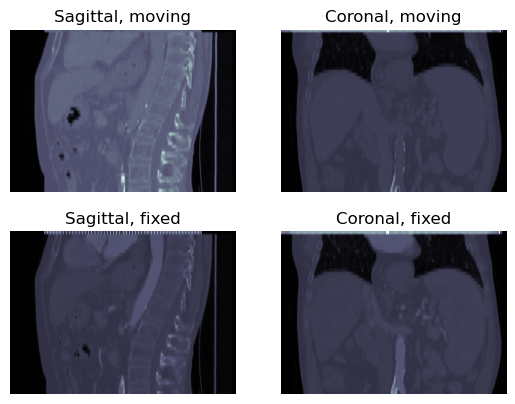

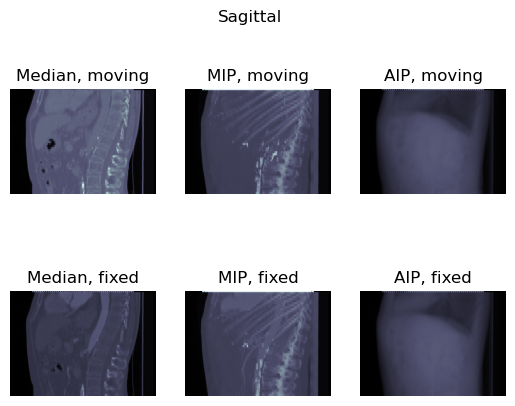

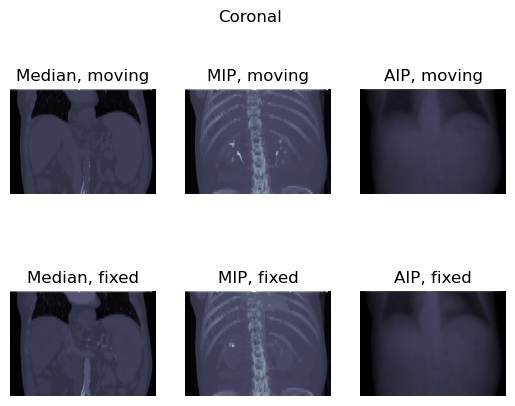

In [19]:
# Show median planes
fig, ax = plt.subplots(2, 2)
ax[0,0].imshow(h.median_sagittal_plane(moving_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,0].set_title('Sagittal, moving')
ax[0,1].imshow(h.median_coronal_plane(moving_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,1].set_title('Coronal, moving')

ax[1,0].imshow(h.median_sagittal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,0].set_title('Sagittal, fixed')
ax[1,1].imshow(h.median_coronal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,1].set_title('Coronal, fixed')
for a in ax.flat:
    a.axis('off')
# fig.suptitle('Median planes')
plt.show()

# Show MIP/AIP/Median planes
fig, ax = plt.subplots(2, 3)
ax[0,0].imshow(h.median_sagittal_plane(moving_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,0].set_title('Median, moving')
ax[0,1].imshow(h.MIP_sagittal_plane(moving_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,1].set_title('MIP, moving')
ax[0,2].imshow(h.AIP_sagittal_plane(moving_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,2].set_title('AIP, moving')

ax[1,0].imshow(h.median_sagittal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,0].set_title('Median, fixed')
ax[1,1].imshow(h.MIP_sagittal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,1].set_title('MIP, fixed')
ax[1,2].imshow(h.AIP_sagittal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,2].set_title('AIP, fixed')
fig.suptitle('Sagittal')
for a in ax.flat:
    a.axis('off')
plt.show()


fig, ax = plt.subplots(2, 3)
ax[0,0].imshow(h.median_coronal_plane(moving_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,0].set_title('Median, moving')
ax[0,1].imshow(h.MIP_coronal_plane(moving_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,1].set_title('MIP, moving')
ax[0,2].imshow(h.AIP_coronal_plane(moving_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,2].set_title('AIP, moving')

ax[1,0].imshow(h.median_coronal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,0].set_title('Median, fixed')
ax[1,1].imshow(h.MIP_coronal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,1].set_title('MIP, fixed')
ax[1,2].imshow(h.AIP_coronal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,2].set_title('AIP, fixed')
fig.suptitle('Coronal')

for a in ax.flat:
    a.axis('off')
plt.show()

In [20]:
result_ls = h.coregisteration(fixed_vol, moving_vol)

[0. 0. 1. 0. 0. 0. 1. 1. 1.]
[1.49011612e-08 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00]
[0.00000000e+00 1.49011612e-08 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00]
[0.         0.         1.00000001 0.         0.         0.
 1.         1.         1.        ]
[0.00000000e+00 0.00000000e+00 1.00000000e+00 1.49011612e-08
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00]
[0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.49011612e-08 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00]
[0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.49011612e-08 1.00000000e+00 1.00000000e+00
 1.00000000e+00]
[0.         0.         1.         0.         0.         0.
 1.00000001 1.         1.        ]
[0.         0.         1.         0.         0.         0.
 1.         1.00000001 1.    

In [21]:
params_ls = result_ls.x

In [22]:
params_ls

array([0., 0., 1., 0., 0., 0., 1., 1., 1.])

In [23]:
transformed_img_ls = h.shift(moving_vol, params_ls[:3])
transformed_img_ls = h.rotate_all_axis(transformed_img_ls, params_ls[3:])
transformed_img_ls = scipy.ndimage.zoom(transformed_img_ls, params_ls[6:], order=1)


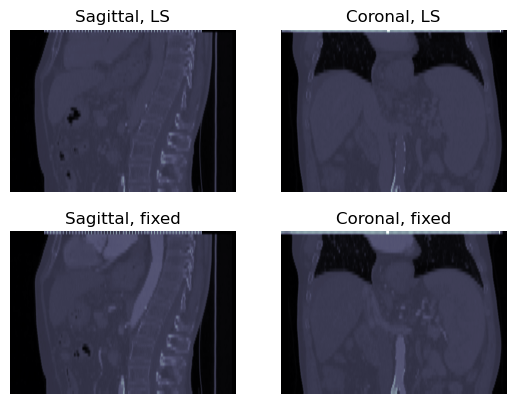

In [24]:

# Visualize the results of coregistration
fig, ax = plt.subplots(2, 2)
ax[0,0].imshow(transformed_img_ls[:, :, fixed_vol.shape[1]//2]  , cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,0].set_title('Sagittal, LS')
ax[0,1].imshow(transformed_img_ls[:, fixed_vol.shape[2]//2, :], cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,1].set_title('Coronal, LS')

ax[1,0].imshow(h.median_sagittal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,0].set_title('Sagittal, fixed')
ax[1,1].imshow(h.median_coronal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,1].set_title('Coronal, fixed')
for a in ax.flat:
    a.axis('off')
# fig.suptitle('Median planes')
plt.show()

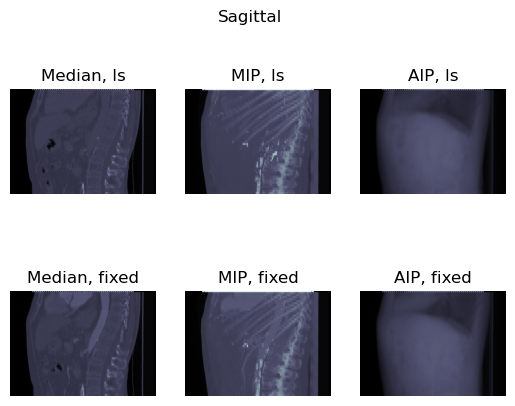

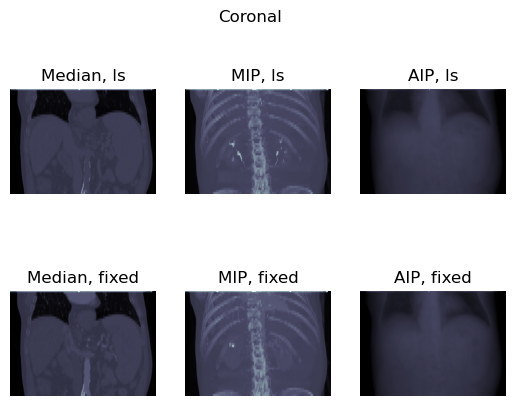

In [25]:


# Show MIP/AIP/Median planes
fig, ax = plt.subplots(2, 3)
ax[0,0].imshow(transformed_img_ls[:, :, fixed_vol.shape[1]//2], cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,0].set_title('Median, ls')
ax[0,1].imshow(np.max(transformed_img_ls, axis=2), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,1].set_title('MIP, ls')
ax[0,2].imshow(np.mean(transformed_img_ls, axis=2), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,2].set_title('AIP, ls')

ax[1,0].imshow(h.median_sagittal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,0].set_title('Median, fixed')
ax[1,1].imshow(h.MIP_sagittal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,1].set_title('MIP, fixed')
ax[1,2].imshow(h.AIP_sagittal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,2].set_title('AIP, fixed')
fig.suptitle('Sagittal')
for a in ax.flat:
    a.axis('off')
plt.show()


fig, ax = plt.subplots(2, 3)
ax[0,0].imshow(transformed_img_ls[:, fixed_vol.shape[2]//2, :], cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,0].set_title('Median, ls')
ax[0,1].imshow(h.MIP_coronal_plane(transformed_img_ls), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,1].set_title('MIP, ls')
ax[0,2].imshow(h.AIP_coronal_plane(transformed_img_ls), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,2].set_title('AIP, ls')

ax[1,0].imshow(h.median_coronal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,0].set_title('Median, fixed')
ax[1,1].imshow(h.MIP_coronal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,1].set_title('MIP, fixed')
ax[1,2].imshow(h.AIP_coronal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,2].set_title('AIP, fixed')
fig.suptitle('Coronal')

for a in ax.flat:
    a.axis('off')
plt.show()

In [26]:
def mutual_information(img_input: np.ndarray, img_reference) -> np.ndarray:
    """ Compute the Shannon Mutual Information between two images. """
    nbins = [10, 10]

    # Compute entropy of each image
    hist = np.histogram(img_input.ravel(), bins=nbins[0])[0]
    prob_distr = hist / np.sum(hist)
    entropy_input = -np.sum(prob_distr * np.log2(prob_distr + 1e-7))
    hist = np.histogram(img_reference.ravel(), bins=nbins[0])[0]
    prob_distr = hist / np.sum(hist)
    entropy_reference = -np.sum(prob_distr * np.log2(prob_distr + 1e-7))

    # Compute joint entropy
    joint_hist = np.histogram2d(img_input.ravel(), img_reference.ravel(), bins=nbins)[0]
    prob_distr = joint_hist / np.sum(joint_hist)
    joint_entropy = -np.sum(prob_distr * np.log2(prob_distr + 1e-7))

    # Compute mutual information
    return entropy_input + entropy_reference - joint_entropy

mutual_info = mutual_information(moving_vol, fixed_vol)
mutual_info_afer= mutual_information(transformed_img_ls, fixed_vol)
print("Mutual Information before registration:", mutual_info)
print("Mutual Information after registration:", mutual_info_afer)

Mutual Information before registration: 0.9589763845246708
Mutual Information after registration: 0.9729854596930303


In [27]:
def mean_squared_error(img1: np.ndarray, img2: np.ndarray) -> float:
    """ Compute the Mean Squared Error between two images. """
    return np.mean((img1 - img2) ** 2)
before = mean_squared_error(fixed_vol, moving_vol)
after  = mean_squared_error(fixed_vol, transformed_img_ls)
print(f"MSE before: {before:.8f}, after: {after:.8f}")


MSE before: 0.00180448, after: 0.00062558


In [28]:
def mean_absolute_error(img_input: np.ndarray, img_reference) -> np.ndarray:
    """ Compute the MAE between two images. """
    return np.mean(np.abs(img_input - img_reference))

mae_before = mean_absolute_error(moving_vol, fixed_vol)
mae_after  = mean_absolute_error(transformed_img_ls, fixed_vol)
print(f"MAE before: {mae_before:.8f}, after: {mae_after:.8f}")

MAE before: 0.01106493, after: 0.00946147


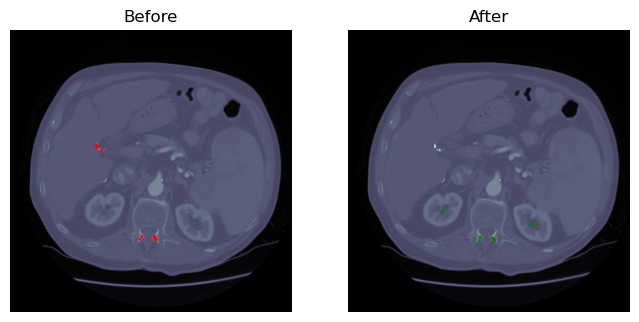

In [29]:
z0 = fixed_vol.shape[0]//2
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Before")
plt.imshow(fixed_vol[z0], cmap='bone')
plt.contour( fixed_vol[z0], levels=[0.5], colors='r' )
plt.axis('off')

plt.subplot(1,2,2)
plt.title("After")
plt.imshow(fixed_vol[z0], cmap='bone')
plt.contour( transformed_img_ls[z0], levels=[0.5], colors='g' )
plt.axis('off')
plt.show()


I got a:
* Mutual Information before registration: 0.9589763845246708
* Mutual Information after registration: 0.8803370118586868
* MSE before: 0.00180448,
* MSE after: 0.00167201
* MAE before: 0.01106493
* MAE after: 0.01222390

So i tried 1 by 1 each 3 parameters and found this:

In [30]:
transformed_img_ls = h.shift(moving_vol, params_ls[:3])
# transformed_img_ls = h.rotate_all_axis(transformed_img_ls, params_ls[3:])
transformed_img_ls = scipy.ndimage.zoom(transformed_img_ls, params_ls[6:], order=1)

mutual_info = mutual_information(moving_vol, fixed_vol)
mutual_info_afer= mutual_information(transformed_img_ls, fixed_vol)
print("Mutual Information before registration:", mutual_info)
print("Mutual Information after registration:", mutual_info_afer)
before = mean_squared_error(fixed_vol, moving_vol)
after  = mean_squared_error(fixed_vol, transformed_img_ls)
print(f"MSE before: {before:.8f}, after: {after:.8f}")
mae_before = mean_absolute_error(moving_vol, fixed_vol)
mae_after  = mean_absolute_error(transformed_img_ls, fixed_vol)
print(f"MAE before: {mae_before:.8f}, after: {mae_after:.8f}")

Mutual Information before registration: 0.9589763845246708
Mutual Information after registration: 0.9729713840336442
MSE before: 0.00180448, after: 0.00062558
MAE before: 0.01106493, after: 0.00946147


## Liver mask
 Visualize the Liver region on the input image space. Assess the correctness of the algorithm, numerically and visually.

In [31]:
def build_mask_volume(seg_file, ct_z_positions, ct_shape):
    ds = pydicom.dcmread(seg_file)
    frames = ds.pixel_array                     # (F, Y, X)
    frame_zs = [
        float(f.PlanePositionSequence[0].ImagePositionPatient[2])
        for f in ds.PerFrameFunctionalGroupsSequence
    ]

    # empty mask volume
    mask_vol = np.zeros(ct_shape, dtype=bool)  # same shape as ct_volume
    ct_z = np.array(ct_z_positions)
    for f, z in enumerate(frame_zs):
        # find the closest slice in the CT volume
        idx = int(np.argmin(np.abs(ct_z - z)))
        # assign the mask
        mask_vol[idx] = frames[f] > 0
    return mask_vol


# directory for liver segmentation file
liver_seg_file = "1196/10_AP_Ax5.00mm_ManualROI_Liver.dcm"

# 1a. Get the Z-locations of each CT slice
ct_z_positions = [float(s.ImagePositionPatient[2]) for s in moving_slices]

# The shape of your CT volume
ct_shape = fixed_vol.shape   # (Z, Y, X)


# Build the boolean mask volume for liver
liver_mask = build_mask_volume(liver_seg_file, ct_z_positions, ct_shape)


In [32]:
print(liver_mask.shape == moving_vol.shape)
print(liver_mask.shape, moving_vol.shape)

True
(52, 512, 512) (52, 512, 512)


In [33]:
import numpy as np

# your per-axis spacing tuple for the moving CT (dz, dy, dx)
dz, dy, dx = 1, mov_spacing_val,mov_spacing_val  

# compute physical volume of one voxel (in mm³ → convert to mL)
voxel_vol_mm3 = dz * dy * dx
voxel_vol_ml  = voxel_vol_mm3 / 1000.0

# how many voxels are “on” in the liver mask?
n_voxels = int(liver_mask.sum())

liver_vol_ml = n_voxels * voxel_vol_ml
print(f"Liver volume ≃ {liver_vol_ml:.1f} mL")


Liver volume ≃ 238.1 mL


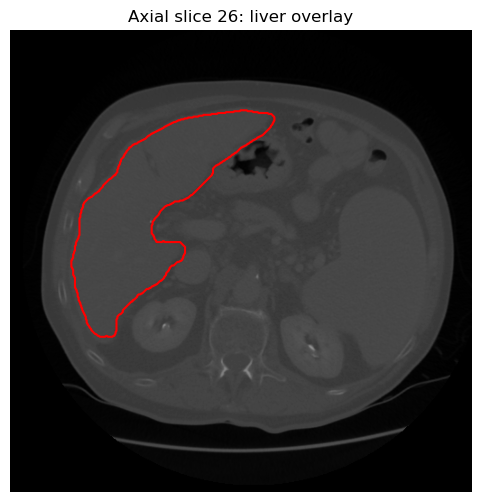

In [34]:
import matplotlib.pyplot as plt

# pick a central slice (or any slice of interest)
z0 = moving_vol.shape[0] // 2

plt.figure(figsize=(6,6))
plt.imshow(moving_vol[z0], cmap='gray', vmin=0, vmax=1)
# draw the liver boundary in red
plt.contour(liver_mask[z0], levels=[0.5], colors='r', linewidths=1.5)
plt.title(f"Axial slice {z0}: liver overlay")
plt.axis('off')
plt.show()


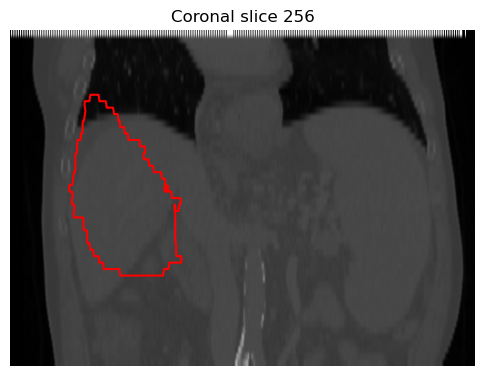

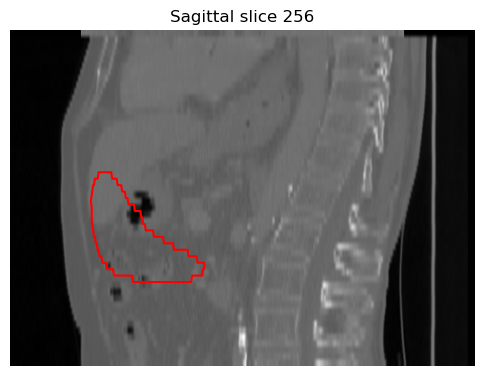

In [35]:
# Coronal
y0 = moving_vol.shape[1] // 2
plt.figure(figsize=(6,6))
plt.imshow(moving_vol[:,y0,:], cmap='gray',
           aspect=pixel_len_mm[0]/pixel_len_mm[1])  # or 1/pixel_spacing_main if you normalized dz→1
plt.contour(liver_mask[:,y0,:], levels=[0.5], colors='r')
plt.title(f"Coronal slice {y0}")
plt.axis('off')
plt.show()

# Sagittal
x0 = moving_vol.shape[2] // 2
plt.figure(figsize=(6,6))
plt.imshow(moving_vol[:,:,x0], cmap='gray',
           aspect=pixel_len_mm[0]/pixel_len_mm[1])
plt.contour(liver_mask[:,:,x0], levels=[0.5], colors='r')
plt.title(f"Sagittal slice {x0}")
plt.axis('off')
plt.show()


In [36]:
liver_centroid = h.find_centroid(liver_mask)
liver_centroid

array([ 28.54480415, 198.69344957, 167.40415394])

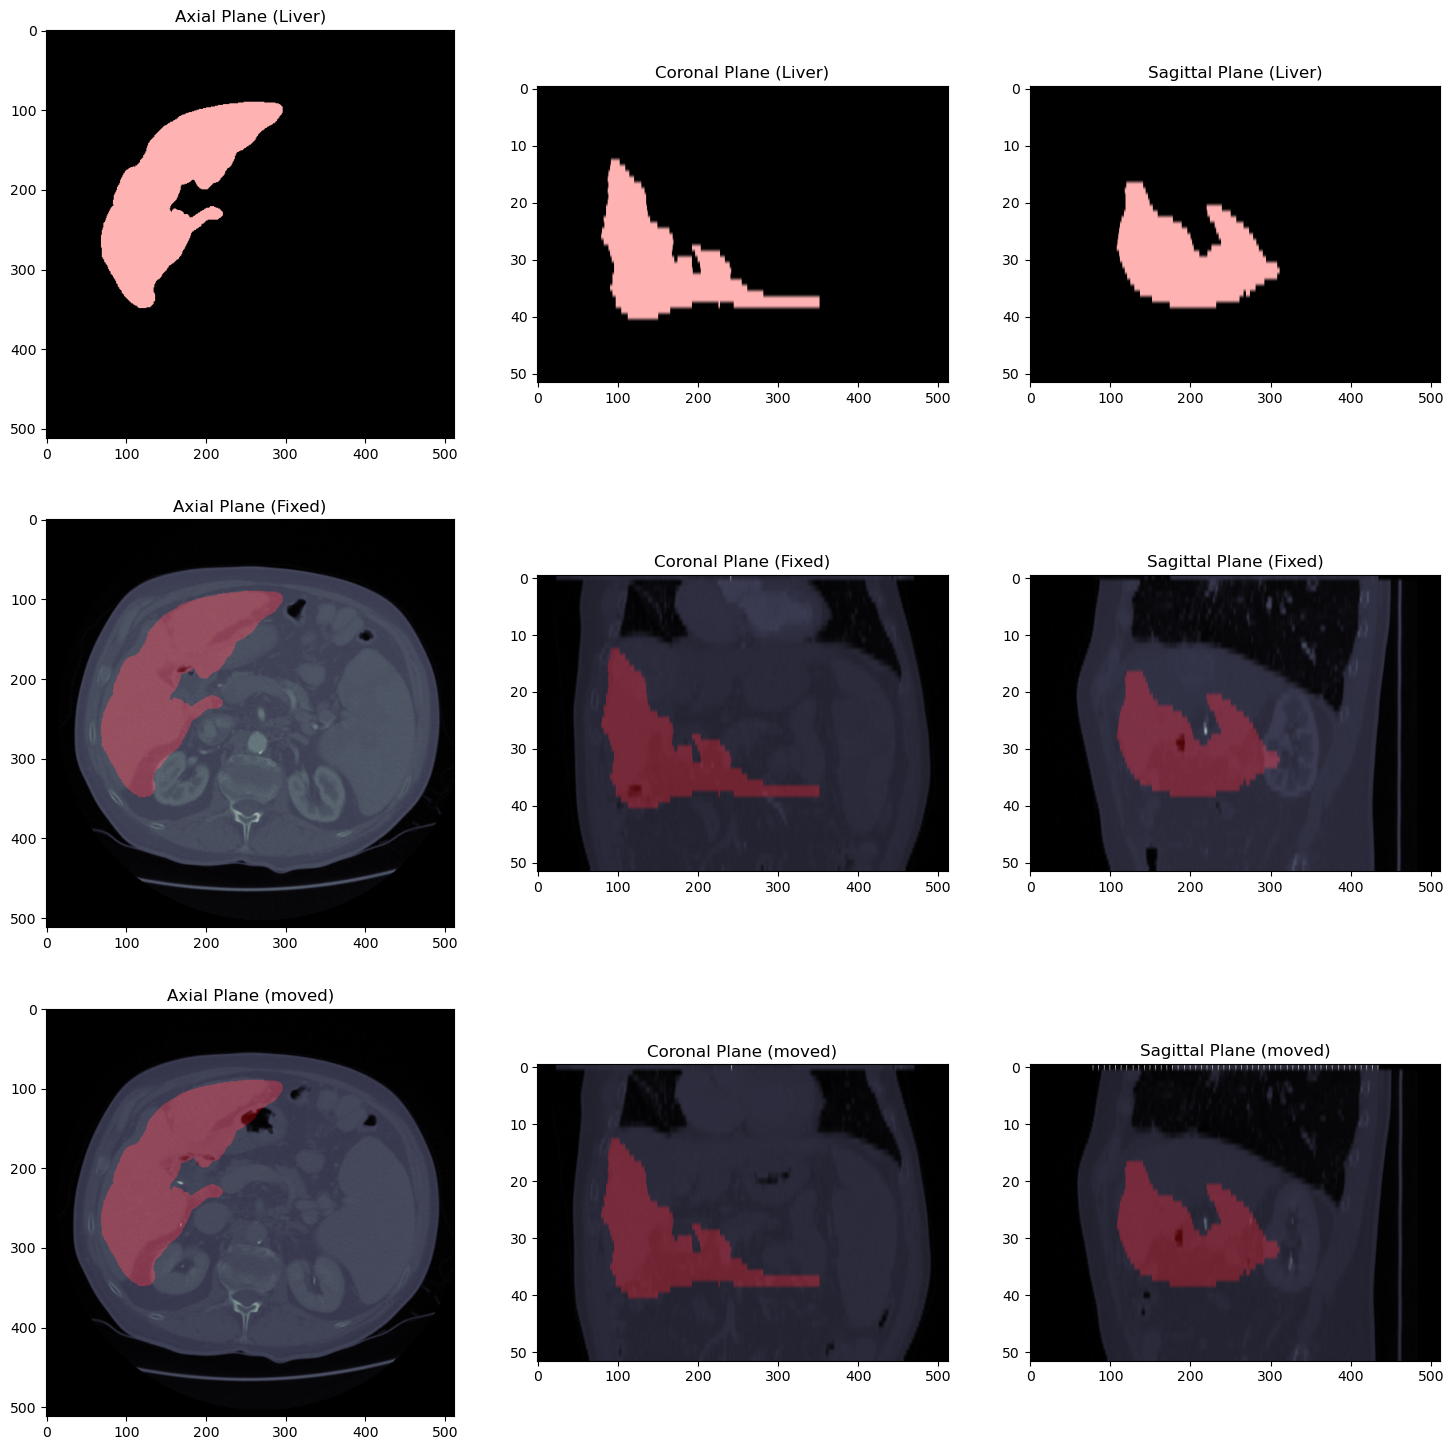

In [37]:
# Visualization
fig, axs = plt.subplots(3, 3, figsize=(18, 18))

axs[0, 0].imshow(h.blend_images(liver_mask[int(liver_centroid[0]), :, :], liver_mask[int(liver_centroid[0]), :, :]), cmap='bone')
axs[0, 0].set_title("Axial Plane (Liver)")

axs[0, 1].imshow(h.blend_images(liver_mask[:, int(liver_centroid[1]), :], liver_mask[:, int(liver_centroid[1]), :]), cmap='bone',aspect=pixel_len_mm[0]/pixel_len_mm[1])
axs[0, 1].set_title("Coronal Plane (Liver)")

axs[0, 2].imshow(h.blend_images(liver_mask[:, :, int(liver_centroid[2])], liver_mask[:, :, int(liver_centroid[2])]), cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
axs[0, 2].set_title("Sagittal Plane (Liver)")

axs[1, 0].imshow(h.blend_images(fixed_vol[int(liver_centroid[0]), :, :], liver_mask[int(liver_centroid[0]), :, :]), cmap='bone')
axs[1, 0].set_title("Axial Plane (Fixed)")

axs[1, 1].imshow(h.blend_images(fixed_vol[:, int(liver_centroid[1]), :], liver_mask[:, int(liver_centroid[1]), :]), cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
axs[1, 1].set_title("Coronal Plane (Fixed)")

axs[1, 2].imshow(h.blend_images(fixed_vol[:, :, int(liver_centroid[2])], liver_mask[:, :, int(liver_centroid[2])]), cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
axs[1, 2].set_title("Sagittal Plane (Fixed)")


# moved Visualization
axs[2, 0].imshow(h.blend_images(moving_vol[int(liver_centroid[0]), :, :], liver_mask[int(liver_centroid[0]), :, :]), cmap='bone')
axs[2, 0].set_title("Axial Plane (moved)")

axs[2, 1].imshow(h.blend_images(moving_vol[:, int(liver_centroid[1]), :], liver_mask[:, int(liver_centroid[1]), :]), cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
axs[2, 1].set_title("Coronal Plane (moved)")

axs[2, 2].imshow(h.blend_images(moving_vol[:, :, int(liver_centroid[2])], liver_mask[:, :, int(liver_centroid[2])]), cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
axs[2, 2].set_title("Sagittal Plane (moved)")
plt.show()